Preprocessing train dataset...
Preprocessing validation dataset...
Preprocessing test dataset...

Verifying train dataset...
Preprocessed files count: {'JumpingJack': 92, 'ApplyLipstick': 85, 'VolleyballSpiking': 87, 'PushUps': 76, 'PullUps': 75}

Visualizing a sample from train dataset...
Loaded sample: /kaggle/working/preprocessed_train/PushUps/v_PushUps_g01_c05.npy
Frames shape: (63, 64, 64, 3)


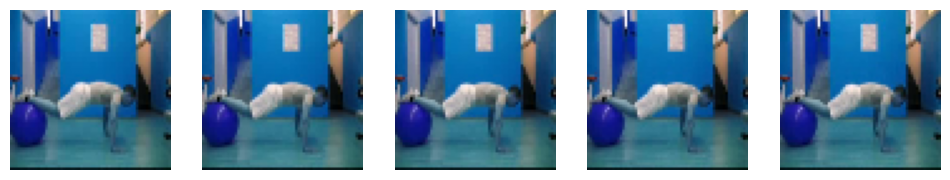

In [1]:
import os
import cv2
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

# Directories for train, val, and test datasets on Kaggle
train_dir = '/kaggle/input/ucf101-action-recognition/train'
val_dir = '/kaggle/input/ucf101-action-recognition/val'
test_dir = '/kaggle/input/ucf101-action-recognition/test'

# Target classes
target_classes = ['PushUps', 'JumpingJack', 'PullUps', 'VolleyballSpiking', 'ApplyLipstick']

# Preprocess video function
def preprocess_video(video_path, target_size=(64, 64), mode="RGB"):
    """
    Preprocesses a video by resizing frames and normalizing pixel values.
    :param video_path: Path to the video file.
    :param target_size: Tuple for resizing (height, width).
    :param mode: 'RGB' or 'GRAY' for color or grayscale processing.
    :return: Array of preprocessed frames.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if mode == "GRAY":
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, target_size)
            frame = frame[:, :, None]  # Add channel dimension for grayscale
        elif mode == "RGB":
            frame = cv2.resize(frame, target_size)
        else:
            raise ValueError("Invalid mode: Choose 'RGB' or 'GRAY'")
        frame = frame / 255.0  # Normalize to [0, 1]
        frames.append(frame)
    cap.release()
    return np.array(frames)

# Process a single video
def process_single_video(video_path, output_dir, class_name, mode="RGB"):
    """
    Processes a single video and saves its preprocessed frames as an .npy file.
    :param video_path: Path to the video file.
    :param output_dir: Directory to save the preprocessed .npy files.
    :param class_name: The class of the video (e.g., 'PushUps').
    :param mode: 'RGB' or 'GRAY'.
    """
    save_dir = os.path.join(output_dir, class_name)
    os.makedirs(save_dir, exist_ok=True)
    try:
        if os.path.exists(video_path):
            frames = preprocess_video(video_path, mode=mode)
            if frames.size > 0:
                # Save as .npy file
                video_name = os.path.splitext(os.path.basename(video_path))[0]
                np.save(os.path.join(save_dir, f"{video_name}.npy"), frames)
    except Exception as e:
        print(f"Error processing {video_path}: {e}")

# Preprocess all videos in a directory
def preprocess_videos_in_dir(base_dir, output_dir, mode="RGB", num_workers=4):
    """
    Preprocesses all videos in a directory that belong to target classes.
    :param base_dir: Base directory containing class folders.
    :param output_dir: Directory to save preprocessed videos.
    :param mode: 'RGB' or 'GRAY'.
    :param num_workers: Number of parallel workers.
    """
    videos_to_process = []
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if class_name in target_classes and os.path.isdir(class_dir):
            for video_file in os.listdir(class_dir):
                if video_file.endswith(('.avi', '.mp4')):  # Add other extensions if needed
                    videos_to_process.append((os.path.join(class_dir, video_file), output_dir, class_name, mode))
    
    with Pool(num_workers) as pool:
        pool.starmap(process_single_video, videos_to_process)

# Verify preprocessed files
def verify_preprocessed_files(output_dir):
    """
    Verifies the preprocessed files and prints the count of .npy files per class.
    :param output_dir: Base directory of preprocessed data.
    """
    files_summary = {}
    for class_name in os.listdir(output_dir):
        class_dir = os.path.join(output_dir, class_name)
        if os.path.isdir(class_dir):
            files_summary[class_name] = len([f for f in os.listdir(class_dir) if f.endswith('.npy')])
    print(f"Preprocessed files count: {files_summary}")

# Visualize a sample preprocessed file
def visualize_sample(output_dir, class_name):
    """
    Visualizes a few frames from a sample preprocessed .npy file.
    :param output_dir: Base directory of preprocessed data.
    :param class_name: The class to visualize (e.g., 'PushUps').
    """
    sample_dir = os.path.join(output_dir, class_name)
    sample_file = os.path.join(sample_dir, os.listdir(sample_dir)[0])  # Load first file
    frames = np.load(sample_file)
    print(f"Loaded sample: {sample_file}")
    print(f"Frames shape: {frames.shape}")
    
    # Display frames
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(frames))):  # Display up to 5 frames
        plt.subplot(1, 5, i + 1)
        if frames.shape[-1] == 1:  # Grayscale
            plt.imshow(frames[i, :, :, 0], cmap='gray')
        else:  # RGB
            plt.imshow(frames[i])
        plt.axis('off')
    plt.show()

# Main function to run preprocessing
def preprocess_all_datasets(train_dir, val_dir, test_dir, output_base_dir, mode="RGB"):
    """
    Preprocess train, val, and test datasets.
    :param train_dir: Path to training dataset.
    :param val_dir: Path to validation dataset.
    :param test_dir: Path to test dataset.
    :param output_base_dir: Base directory to save preprocessed datasets.
    :param mode: 'RGB' or 'GRAY'.
    """
    output_train_dir = os.path.join(output_base_dir, "preprocessed_train")
    output_val_dir = os.path.join(output_base_dir, "preprocessed_val")
    output_test_dir = os.path.join(output_base_dir, "preprocessed_test")
    
    print("Preprocessing train dataset...")
    preprocess_videos_in_dir(train_dir, output_train_dir, mode=mode)
    print("Preprocessing validation dataset...")
    preprocess_videos_in_dir(val_dir, output_val_dir, mode=mode)
    print("Preprocessing test dataset...")
    preprocess_videos_in_dir(test_dir, output_test_dir, mode=mode)

    # Verify and visualize
    print("\nVerifying train dataset...")
    verify_preprocessed_files(output_train_dir)
    print("\nVisualizing a sample from train dataset...")
    visualize_sample(output_train_dir, 'PushUps')  # Change class to visualize another class

# Run the preprocessing pipeline
output_base_dir = '/kaggle/working'
preprocess_all_datasets(train_dir, val_dir, test_dir, output_base_dir, mode="RGB")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Shape of X_batch (inputs): (4, 10, 64, 64, 3)
Shape of Y_batch (outputs): (4, 5, 64, 64, 3)
Training ConvLSTM model...
Epoch 1/10


I0000 00:00:1733165570.736515    2356 service.cc:145] XLA service 0x59b817f79d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733165570.736587    2356 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   1/1037 ━━━━━━━━━━━━━━━━━━━━ 2:42:58 9s/step - loss: 0.1587

I0000 00:00:1733165575.123915    2356 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1037/1037 ━━━━━━━━━━━━━━━━━━━━ 143s 129ms/step - loss: 0.0274 - val_loss: 0.0131
Epoch 2/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 133s 128ms/step - loss: 0.0114 - val_loss: 0.0132
Epoch 3/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 133s 128ms/step - loss: 0.0104 - val_loss: 0.0115
Epoch 4/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 133s 128ms/step - loss: 0.0087 - val_loss: 0.0121
Epoch 5/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 132s 128ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 6/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 133s 128ms/step - loss: 0.0074 - val_loss: 0.0112
Epoch 7/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 132s 128ms/step - loss: 0.0074 - val_loss: 0.0120
Epoch 8/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 132s 128ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 9/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 133s 128ms/step - loss: 0.0072 - val_loss: 0.0119
Epoch 10/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 132s 128ms/step - loss: 0.0066 - val_loss: 0.0096
Evaluating ConvLSTM model on test set...
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss:

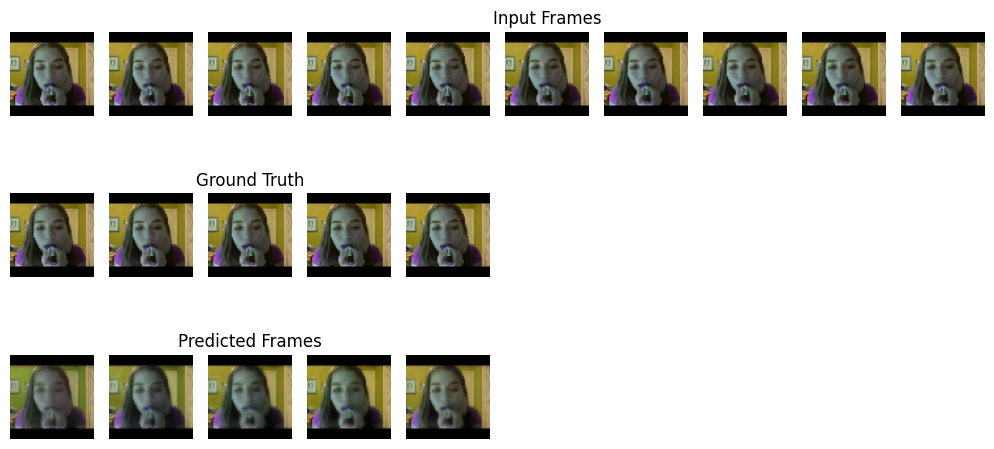

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Paths to preprocessed datasets
preprocessed_train_dir = '/kaggle/working/preprocessed_train'
preprocessed_val_dir = '/kaggle/working/preprocessed_val'
preprocessed_test_dir = '/kaggle/working/preprocessed_test'

# Target classes
target_classes = ['PushUps', 'JumpingJack', 'PullUps', 'VolleyballSpiking', 'ApplyLipstick']

# Generator function for data
def data_generator(preprocessed_dir, input_frames=10, output_frames=5, batch_size=16):
    """
    Data generator to yield batches of input-output pairs for training/validation.
    """
    X, Y = [], []
    while True:  # Infinite loop for the generator
        for class_name in os.listdir(preprocessed_dir):
            class_dir = os.path.join(preprocessed_dir, class_name)
            if os.path.isdir(class_dir):
                for file in os.listdir(class_dir):
                    if file.endswith('.npy'):
                        video_data = np.load(os.path.join(class_dir, file))
                        # Create input-output pairs
                        total_frames = len(video_data)
                        max_start_idx = total_frames - input_frames - output_frames
                        if max_start_idx <= 0:
                            continue  # Skip if video is too short
                        for i in range(0, max_start_idx, input_frames + output_frames):
                            X.append(video_data[i:i+input_frames])  # Input: sequence of frames
                            Y.append(video_data[i+input_frames:i+input_frames+output_frames])  # Output: next frames
                            if len(X) == batch_size:  # Yield batch when full
                                yield np.array(X), np.array(Y)
                                X, Y = [], []

# Model building: ConvLSTM
def build_convlstm_model(input_frames, output_frames, img_size=(64, 64), channels=3):
    """
    Builds a ConvLSTM model for video prediction.
    """
    model = Sequential([
        # ConvLSTM layers
        ConvLSTM2D(
            filters=64,
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True,
            input_shape=(input_frames, img_size[0], img_size[1], channels)
        ),
        BatchNormalization(),
        ConvLSTM2D(
            filters=64,
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True
        ),
        BatchNormalization(),
        ConvLSTM2D(
            filters=64,
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True
        ),
        BatchNormalization(),
        # Conv3D layer to predict the next frames
        Conv3D(
            filters=channels,
            kernel_size=(3, 3, 3),
            activation='sigmoid',
            padding='same',
            strides=(input_frames // output_frames, 1, 1)
        )
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Define parameters
input_frames = 10
output_frames = 5
batch_size = 4
epochs = 10

# Create generators
train_gen = data_generator(preprocessed_train_dir, input_frames, output_frames, batch_size)
val_gen = data_generator(preprocessed_val_dir, input_frames, output_frames, batch_size)

# Calculate steps per epoch (approximate)
def count_samples(preprocessed_dir):
    count = 0
    for class_name in os.listdir(preprocessed_dir):
        class_dir = os.path.join(preprocessed_dir, class_name)
        if os.path.isdir(class_dir):
            count += len([f for f in os.listdir(class_dir) if f.endswith('.npy')])
    return count

train_samples = count_samples(preprocessed_train_dir)
val_samples = count_samples(preprocessed_val_dir)

train_steps = (train_samples * 10) // batch_size  # Approximate steps per epoch
val_steps = (val_samples * 10) // batch_size

# Build ConvLSTM model
convlstm_model = build_convlstm_model(input_frames, output_frames)

# Verify generator outputs (sanity check)
X_batch, Y_batch = next(train_gen)
print(f"Shape of X_batch (inputs): {X_batch.shape}")  # Should be (batch_size, input_frames, 64, 64, 3)
print(f"Shape of Y_batch (outputs): {Y_batch.shape}")  # Should be (batch_size, output_frames, 64, 64, 3)

# Callbacks for saving the model and early stopping
callbacks = [
    ModelCheckpoint('/kaggle/working/convlstm_best_model1.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, monitor='val_loss')
]

# Train the model
print("Training ConvLSTM model...")
convlstm_model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    epochs=epochs,
    callbacks=callbacks
)

# Save the final model
convlstm_model.save('/kaggle/working/convlstm_final_model1.keras')

# Evaluate on test set
test_gen = data_generator(preprocessed_test_dir, input_frames, output_frames, batch_size)
test_samples = count_samples(preprocessed_test_dir)
test_steps = (test_samples * 10) // batch_size

print("Evaluating ConvLSTM model on test set...")
test_loss = convlstm_model.evaluate(test_gen, steps=test_steps)
print(f"Test Loss (MSE): {test_loss}")

# Visualize Predictions
def visualize_predictions(model, test_gen, batch_size=1):
    """
    Visualizes predictions for a single batch of test data.
    """
    X_test, Y_true = next(test_gen)
    Y_pred = model.predict(X_test)

    for i in range(batch_size):
        plt.figure(figsize=(15, 5))
        total_frames = input_frames + output_frames
        # Show input frames
        for j in range(input_frames):
            plt.subplot(3, total_frames, j + 1)
            plt.imshow(X_test[i, j, :, :, :] if X_test.shape[-1] == 3 else X_test[i, j, :, :, 0], cmap='gray')
            plt.axis('off')
            if j == input_frames // 2:
                plt.title("Input Frames")
        # Show ground truth
        for j in range(output_frames):
            plt.subplot(3, total_frames, total_frames + j + 1)
            plt.imshow(Y_true[i, j, :, :, :] if Y_true.shape[-1] == 3 else Y_true[i, j, :, :, 0], cmap='gray')
            plt.axis('off')
            if j == output_frames // 2:
                plt.title("Ground Truth")
        # Show predictions
        for j in range(output_frames):
            plt.subplot(3, total_frames, 2 * total_frames + j + 1)
            plt.imshow(Y_pred[i, j, :, :, :] if Y_pred.shape[-1] == 3 else Y_pred[i, j, :, :, 0], cmap='gray')
            plt.axis('off')
            if j == output_frames // 2:
                plt.title("Predicted Frames")
        plt.tight_layout()
        plt.show()

# Visualize predictions
print("Visualizing predictions...")
visualize_predictions(convlstm_model, test_gen, batch_size=1)


In [3]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(Y_true, Y_pred):
    """
    Calculates SSIM for a batch of predictions and ground truth.
    :param Y_true: Ground truth frames (batch_size, output_frames, height, width, channels).
    :param Y_pred: Predicted frames (batch_size, output_frames, height, width, channels).
    :return: Average SSIM for the batch.
    """
    batch_size, output_frames, height, width, channels = Y_true.shape
    ssim_values = []
    
    for b in range(batch_size):
        for t in range(output_frames):
            # Convert to grayscale if RGB
            if channels == 3:
                true_frame = np.dot(Y_true[b, t, :, :, :3], [0.2989, 0.5870, 0.1140])
                pred_frame = np.dot(Y_pred[b, t, :, :, :3], [0.2989, 0.5870, 0.1140])
            else:
                true_frame = Y_true[b, t, :, :, 0]
                pred_frame = Y_pred[b, t, :, :, 0]
            # Compute SSIM for the frame
            ssim_value = ssim(true_frame, pred_frame, data_range=pred_frame.max() - pred_frame.min())
            ssim_values.append(ssim_value)
    
    return np.mean(ssim_values)

# Evaluate SSIM on test set
test_gen = data_generator(preprocessed_test_dir, input_frames, output_frames, batch_size=4)
X_test, Y_true = next(test_gen)
Y_pred = convlstm_model.predict(X_test)

print(f"Shape of X_test: {X_test.shape}, Shape of Y_true: {Y_true.shape}, Shape of Y_pred: {Y_pred.shape}")

# Calculate SSIM
average_ssim = calculate_ssim(Y_true, Y_pred)
print(f"Average SSIM: {average_ssim:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Shape of X_test: (4, 10, 64, 64, 3), Shape of Y_true: (4, 5, 64, 64, 3), Shape of Y_pred: (4, 5, 64, 64, 3)
Average SSIM: 0.5258


Training PredRNN model...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733166946.385248    2357 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_tanh_fusion_3', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_tanh_fusion_29', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_tanh_fusion_30', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_multiply_tanh_fusion', 16 bytes spill stores, 12 bytes spill loads



103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0489

I0000 00:00:1733166974.053736    2357 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_7', 12 bytes spill stores, 12 bytes spill loads



103/103 ━━━━━━━━━━━━━━━━━━━━ 60s 282ms/step - loss: 0.0487 - val_loss: 0.0168
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - loss: 0.0150 - val_loss: 0.0193
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - loss: 0.0095 - val_loss: 0.0098
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - loss: 0.0083 - val_loss: 0.0106
Epoch 9/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - loss: 0.0077 - val_loss: 0.0084
Epoch 10/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - loss: 0.0070 - val_loss: 0.0094
Evaluating PredRNN model on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1733167192.686451    2357 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_7', 12 bytes spill stores, 12 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average MSE: 0.008724455748348521, Average SSIM: 0.8186848179493972
Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


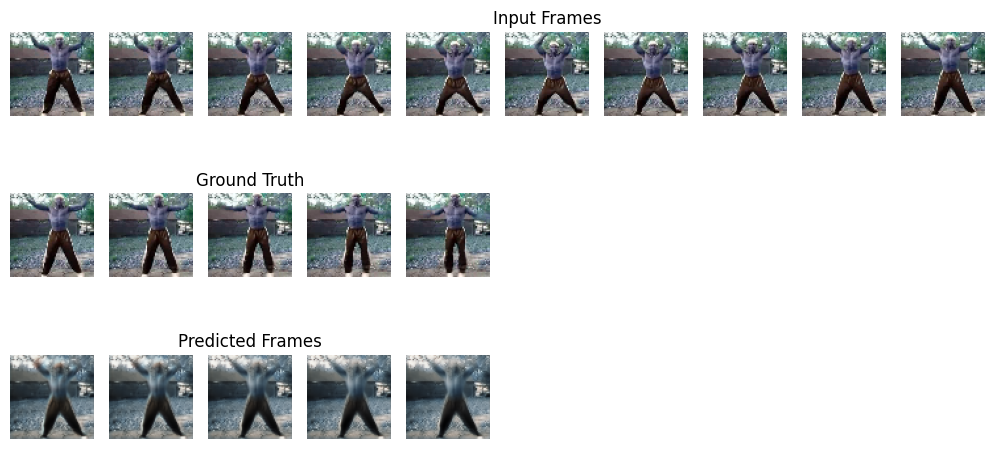

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Paths to preprocessed datasets
preprocessed_train_dir = '/kaggle/working/preprocessed_train'
preprocessed_val_dir = '/kaggle/working/preprocessed_val'
preprocessed_test_dir = '/kaggle/working/preprocessed_test'

# DataGenerator class
class DataGenerator(Sequence):
    def __init__(self, preprocessed_dir, input_frames=10, output_frames=5, batch_size=4):
        self.preprocessed_dir = preprocessed_dir
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.batch_size = batch_size
        self.file_list = self._get_file_list()
        self.indexes = np.arange(len(self.file_list))
        
    def _get_file_list(self):
        file_list = []
        for class_name in os.listdir(self.preprocessed_dir):
            class_dir = os.path.join(self.preprocessed_dir, class_name)
            if os.path.isdir(class_dir):
                for file in os.listdir(class_dir):
                    if file.endswith('.npy'):
                        file_list.append(os.path.join(class_dir, file))
        return file_list
    
    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))
    
    def __getitem__(self, index):
        X_batch = []
        Y_batch = []
        batch_files = self.file_list[index * self.batch_size:(index + 1) * self.batch_size]
        for file in batch_files:
            video_data = np.load(file)
            total_frames = len(video_data)
            max_start_idx = total_frames - self.input_frames - self.output_frames
            if max_start_idx <= 0:
                continue  # Skip if video is too short
            start_idx = np.random.randint(0, max_start_idx + 1)
            X = video_data[start_idx:start_idx + self.input_frames]
            Y = video_data[start_idx + self.input_frames:start_idx + self.input_frames + self.output_frames]
            X_batch.append(X)
            Y_batch.append(Y)
        X_batch = np.array(X_batch)
        Y_batch = np.array(Y_batch)
        return X_batch, Y_batch

# ST_LSTM_Cell class
class ST_LSTM_Cell(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ST_LSTM_Cell, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        # Define convolutional layers
        self.conv_xh = layers.Conv2D(
            filters=4 * filters,
            kernel_size=kernel_size,
            padding='same'
        )
        self.conv_m = layers.Conv2D(
            filters=3 * filters,
            kernel_size=kernel_size,
            padding='same'
        )
        self.conv_o = layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding='same'
        )

    def call(self, x_t, h_prev, c_prev, m_prev):
        # Compute gates
        xh = self.conv_xh(tf.concat([x_t, h_prev], axis=-1))
        i_xh, f_xh, g_xh, o_xh = tf.split(xh, num_or_size_splits=4, axis=-1)

        m = self.conv_m(m_prev)
        i_m, f_m, m_m = tf.split(m, num_or_size_splits=3, axis=-1)

        # Update states
        i_t = tf.sigmoid(i_xh + i_m)
        f_t = tf.sigmoid(f_xh + f_m)
        g_t = tf.tanh(g_xh)
        c_t = f_t * c_prev + i_t * g_t

        m_t = f_t * m_prev + i_t * tf.tanh(m_m)

        o_t = tf.sigmoid(o_xh + self.conv_o(m_t))
        h_t = o_t * tf.tanh(c_t)

        return h_t, c_t, m_t

# PredRNNLayer
class PredRNNLayer(tf.keras.layers.Layer):
    def __init__(self, filters, num_layers, input_frames, output_frames, kernel_size=(3, 3), **kwargs):
        super(PredRNNLayer, self).__init__(**kwargs)
        self.filters = filters
        self.num_layers = num_layers
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.kernel_size = kernel_size
        # Create ST-LSTM cells for each layer
        self.stlstm_cells = [ST_LSTM_Cell(filters, kernel_size) for _ in range(num_layers)]
        # Output convolution
        self.conv_output = layers.Conv2D(
            filters=3,  # Assuming RGB output
            kernel_size=(1, 1),
            activation='sigmoid',
            padding='same'
        )

    def call(self, inputs, training=None):
        # inputs.shape: (batch_size, input_frames, height, width, channels)
        input_frames = self.input_frames
        output_frames = self.output_frames
        total_frames = input_frames + output_frames

        # Get static shape dimensions if possible
        batch_size = tf.shape(inputs)[0]
        height = inputs.shape[2]
        width = inputs.shape[3]
        channels = inputs.shape[4]

        # Handle dynamic height and width
        if height is None:
            height = tf.shape(inputs)[2]
        if width is None:
            width = tf.shape(inputs)[3]

        # Initialize states
        h_t = [tf.zeros((batch_size, height, width, self.filters)) for _ in range(self.num_layers)]
        c_t = [tf.zeros((batch_size, height, width, self.filters)) for _ in range(self.num_layers)]
        m_t = tf.zeros((batch_size, height, width, self.filters))

        outputs = []

        for t in range(total_frames):
            if t < input_frames:
                x_t = inputs[:, t]
            else:
                x_t = x_pred  # Use last predicted frame

            h_t_prev = h_t.copy()
            c_t_prev = c_t.copy()
            m_t_prev = m_t

            for l in range(self.num_layers):
                if l == 0:
                    h, c, m_t = self.stlstm_cells[l](x_t, h_t_prev[l], c_t_prev[l], m_t_prev)
                else:
                    h, c, m_t = self.stlstm_cells[l](h_t[l-1], h_t_prev[l], c_t_prev[l], m_t)
                h_t[l] = h
                c_t[l] = c

            x_pred = self.conv_output(h_t[-1])

            if t >= input_frames:
                outputs.append(x_pred)

        outputs = tf.stack(outputs, axis=1)
        return outputs

# Build PredRNN model
def build_predrnn_model(input_frames, output_frames, img_size=(64, 64), channels=3, filters=64, num_layers=4):
    inputs = layers.Input(shape=(input_frames, img_size[0], img_size[1], channels))
    outputs = PredRNNLayer(
        filters=filters,
        num_layers=num_layers,
        input_frames=input_frames,
        output_frames=output_frames
    )(inputs)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Training code
# Define parameters
input_frames = 10
output_frames = 5
batch_size = 4
epochs = 10

# Create generators
train_gen = DataGenerator(preprocessed_train_dir, input_frames, output_frames, batch_size)
val_gen = DataGenerator(preprocessed_val_dir, input_frames, output_frames, batch_size)

# Build PredRNN model
predrnn_model = build_predrnn_model(input_frames, output_frames)

# Callbacks
callbacks = [
    ModelCheckpoint('/kaggle/working/predrnn_best_model.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, monitor='val_loss')
]

# Train the model
print("Training PredRNN model...")
predrnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)

# Evaluate the model
def evaluate_model(model, test_gen, steps):
    total_mse = 0
    total_ssim = 0
    count = 0
    for i in range(steps):
        X_test, Y_true = test_gen.__getitem__(i)
        Y_pred = model.predict(X_test)
        mse = np.mean((Y_true - Y_pred) ** 2)
        total_mse += mse

        # Compute SSIM for each frame
        batch_ssim = 0
        for b in range(Y_true.shape[0]):
            for t in range(Y_true.shape[1]):
                true_frame = Y_true[b, t]
                pred_frame = Y_pred[b, t]
                # Convert to grayscale if necessary
                if true_frame.shape[-1] == 3:
                    true_frame_gray = tf.image.rgb_to_grayscale(true_frame)
                    pred_frame_gray = tf.image.rgb_to_grayscale(pred_frame)
                    true_frame_gray = true_frame_gray.numpy().squeeze()
                    pred_frame_gray = pred_frame_gray.numpy().squeeze()
                else:
                    true_frame_gray = true_frame.squeeze()
                    pred_frame_gray = pred_frame.squeeze()
                ssim_index = ssim(true_frame_gray, pred_frame_gray, data_range=1)
                batch_ssim += ssim_index
        avg_batch_ssim = batch_ssim / (Y_true.shape[0] * Y_true.shape[1])
        total_ssim += avg_batch_ssim
        count += 1
    avg_mse = total_mse / count
    avg_ssim = total_ssim / count
    print(f"Average MSE: {avg_mse}, Average SSIM: {avg_ssim}")

# Evaluate on Test Set
test_gen = DataGenerator(preprocessed_test_dir, input_frames, output_frames, batch_size)
test_steps = len(test_gen)

print("Evaluating PredRNN model on test set...")
evaluate_model(predrnn_model, test_gen, steps=test_steps)

# Visualize Predictions
def visualize_predictions(model, test_gen, batch_size=1):
    """
    Visualizes predictions for a single batch of test data.
    """
    X_test, Y_true = test_gen.__getitem__(0)
    Y_pred = model.predict(X_test)

    for i in range(batch_size):
        plt.figure(figsize=(15, 5))
        total_frames = input_frames + output_frames
        # Show input frames
        for j in range(input_frames):
            plt.subplot(3, total_frames, j + 1)
            plt.imshow(X_test[i, j])
            plt.axis('off')
            if j == input_frames // 2:
                plt.title("Input Frames")
        # Show ground truth
        for j in range(output_frames):
            plt.subplot(3, total_frames, total_frames + j + 1)
            plt.imshow(Y_true[i, j])
            plt.axis('off')
            if j == output_frames // 2:
                plt.title("Ground Truth")
        # Show predictions
        for j in range(output_frames):
            plt.subplot(3, total_frames, 2 * total_frames + j + 1)
            plt.imshow(Y_pred[i, j])
            plt.axis('off')
            if j == output_frames // 2:
                plt.title("Predicted Frames")
        plt.tight_layout()
        plt.show()

print("Visualizing predictions...")
visualize_predictions(predrnn_model, test_gen, batch_size=1)


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

class DataGenerator(Sequence):
    def __init__(self, preprocessed_dir, input_frames=10, output_frames=5, batch_size=4):
        self.preprocessed_dir = preprocessed_dir
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.batch_size = batch_size
        self.file_list = self._get_file_list()
        self.indexes = np.arange(len(self.file_list))
        self.on_epoch_end()

    def _get_file_list(self):
        file_list = []
        for class_name in os.listdir(self.preprocessed_dir):
            class_dir = os.path.join(self.preprocessed_dir, class_name)
            if os.path.isdir(class_dir):
                for file in os.listdir(class_dir):
                    if file.endswith('.npy'):
                        file_list.append(os.path.join(class_dir, file))
        return file_list

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        X_batch, Y_batch = [], []
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        for idx in batch_indexes:
            file = self.file_list[idx]
            video_data = np.load(file)
            if video_data.max() > 1.0:
                video_data = video_data / 255.0
            total_frames = len(video_data)
            max_start_idx = total_frames - self.input_frames - self.output_frames
            if max_start_idx <= 0:
                continue
            start_idx = np.random.randint(0, max_start_idx + 1)
            X = video_data[start_idx:start_idx + self.input_frames]
            Y = video_data[start_idx + self.input_frames:start_idx + self.input_frames + self.output_frames]
            X_batch.append(X)
            Y_batch.append(Y)
        return np.array(X_batch), np.array(Y_batch)

class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        
        # Define layers
        self.conv1 = layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.relu2 = layers.ReLU()
        self.add = layers.Add()
        
        # Add skip connection if needed
        self.skip_connection = None
        
    def build(self, input_shape):
        if input_shape[-1] != self.filters:
            self.skip_connection = layers.Conv2D(self.filters, 1, padding='same')
        super(ResidualBlock, self).build(input_shape)

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        
        if self.skip_connection is not None:
            inputs = self.skip_connection(inputs)
            
        x = self.add([inputs, x])
        return self.relu2(x)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.filters)

    def get_config(self):
        config = super(ResidualBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size
        })
        return config

def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=inputs.shape[-1], dropout=dropout
    )(x, x)
    x = layers.Add()([inputs, attention_output])
    x = layers.Dropout(dropout)(x)
    
    x2 = layers.LayerNormalization(epsilon=1e-6)(x)
    ffn_output = layers.Dense(ff_dim, activation='relu')(x2)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    x = layers.Add()([x, ffn_output])
    return layers.Dropout(dropout)(x)

def compute_gradient_loss(y_true, y_pred):
    batch_size = tf.shape(y_true)[0]
    frames = tf.shape(y_true)[1]
    
    y_true_reshaped = tf.reshape(y_true, [-1] + y_true.shape[2:].as_list())
    y_pred_reshaped = tf.reshape(y_pred, [-1] + y_pred.shape[2:].as_list())
    
    dy_true, dx_true = tf.image.image_gradients(y_true_reshaped)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred_reshaped)
    
    gradient_loss = tf.reduce_mean(tf.square(dy_true - dy_pred) + tf.square(dx_true - dx_pred))
    return gradient_loss

def build_enhanced_transformer_video_model(
    input_frames, output_frames, img_size=(64, 64), channels=3,
    d_model=256, num_heads=8, num_layers=3, ff_dim=512, dropout_rate=0.1
):
    inputs = layers.Input(shape=(input_frames, img_size[0], img_size[1], channels))
    
    # Encoder network
    x = layers.TimeDistributed(layers.Conv2D(64, (7, 7), strides=1, padding='same'))(inputs)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.ReLU())(x)
    
    # First set of residual blocks
    for _ in range(2):
        res_block = ResidualBlock(64)
        x = layers.TimeDistributed(res_block)(x)
    
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), strides=2, padding='same'))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.ReLU())(x)
    
    # Second set of residual blocks
    for _ in range(2):
        res_block = ResidualBlock(128)
        x = layers.TimeDistributed(res_block)(x)
    
    x = layers.TimeDistributed(layers.Flatten())(x)
    x = layers.TimeDistributed(layers.Dense(d_model))(x)
    
    # Position encoding
    positions = tf.range(start=0, limit=input_frames, delta=1)
    pos_encoding = layers.Embedding(input_dim=input_frames, output_dim=d_model)(positions)
    x = layers.Add()([x, tf.expand_dims(pos_encoding, 0)])
    
    # Transformer encoders
    for _ in range(num_layers):
        x = transformer_encoder(x, num_heads, ff_dim, dropout_rate)
    
    # Decoder
    outputs = []
    decoder_input = x[:, -1:, :]
    
    for _ in range(output_frames):
        y = decoder_input
        y = layers.LayerNormalization(epsilon=1e-6)(y)
        
        y = layers.Dense(d_model * 2, activation='relu')(y)
        y = layers.Dropout(dropout_rate)(y)
        y = layers.Dense(32 * 32 * 128)(y)
        
        y = layers.Reshape((-1, 32, 32, 128))(y)
        
        y = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same')(y[:, 0])
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)
        
        res_block = ResidualBlock(64)
        y = res_block(y)
        
        y = layers.Conv2D(channels, (7, 7), activation='sigmoid', padding='same')(y)
        
        y = layers.Lambda(lambda z: tf.expand_dims(z, axis=1))(y)
        outputs.append(y)
        
        decoder_input = layers.Dense(d_model)(layers.Flatten()(y[:, 0]))
        decoder_input = layers.Lambda(lambda z: tf.expand_dims(z, axis=1))(decoder_input)
    
    outputs = layers.Concatenate(axis=1)(outputs)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    def custom_loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        grad_loss = compute_gradient_loss(y_true, y_pred)
        return mse_loss + 0.1 * grad_loss
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=custom_loss,
        metrics=['mse']
    )
    return model

# Training parameters
input_frames = 10
output_frames = 5
img_height, img_width, channels = 64, 64, 3
batch_size = 4
epochs = 30

# Initialize data generators
train_gen = DataGenerator(preprocessed_train_dir, input_frames, output_frames, batch_size)
val_gen = DataGenerator(preprocessed_val_dir, input_frames, output_frames, batch_size)
test_gen = DataGenerator(preprocessed_test_dir, input_frames, output_frames, batch_size)

# Build and train the model
model = build_enhanced_transformer_video_model(
    input_frames, output_frames, 
    img_size=(img_height, img_width), 
    channels=channels
)

# Callbacks
callbacks = [
    ModelCheckpoint(
        'enhanced_transformer_model.keras', 
        save_best_only=True, 
        monitor='val_loss'
    ),
    EarlyStopping(
        patience=7, 
        monitor='val_loss', 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train the model
print("Training enhanced transformer-based video prediction model...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)

Training enhanced transformer-based video prediction model...
Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 167s 453ms/step - loss: 0.0982 - mse: 0.0907 - val_loss: 0.0863 - val_mse: 0.0832 - learning_rate: 1.0000e-04
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 0.0687 - mse: 0.0646 - val_loss: 0.0945 - val_mse: 0.0912 - learning_rate: 1.0000e-04
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 0.0626 - mse: 0.0589 - val_loss: 0.0984 - val_mse: 0.0950 - learning_rate: 1.0000e-04
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 0.0578 - mse: 0.0543 - val_loss: 0.0911 - val_mse: 0.0876 - learning_rate: 1.0000e-04
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 39s 380ms/step - loss: 0.0552 - mse: 0.0519 - val_loss: 0.0827 - val_mse: 0.0792 - learning_rate: 5.0000e-05
Epoch 6/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 397ms/step - loss: 0.0523 - mse: 0.0492 - val_loss: 0.0626 - val_mse: 0.0592 - learning_rate: 5.0000e-05
Epoch 7/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 40s

Visualizing predictions...
X_test shape: (1, 10, 64, 64, 3)
Y_true shape: (1, 5, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Y_pred shape: (1, 5, 64, 64, 3)


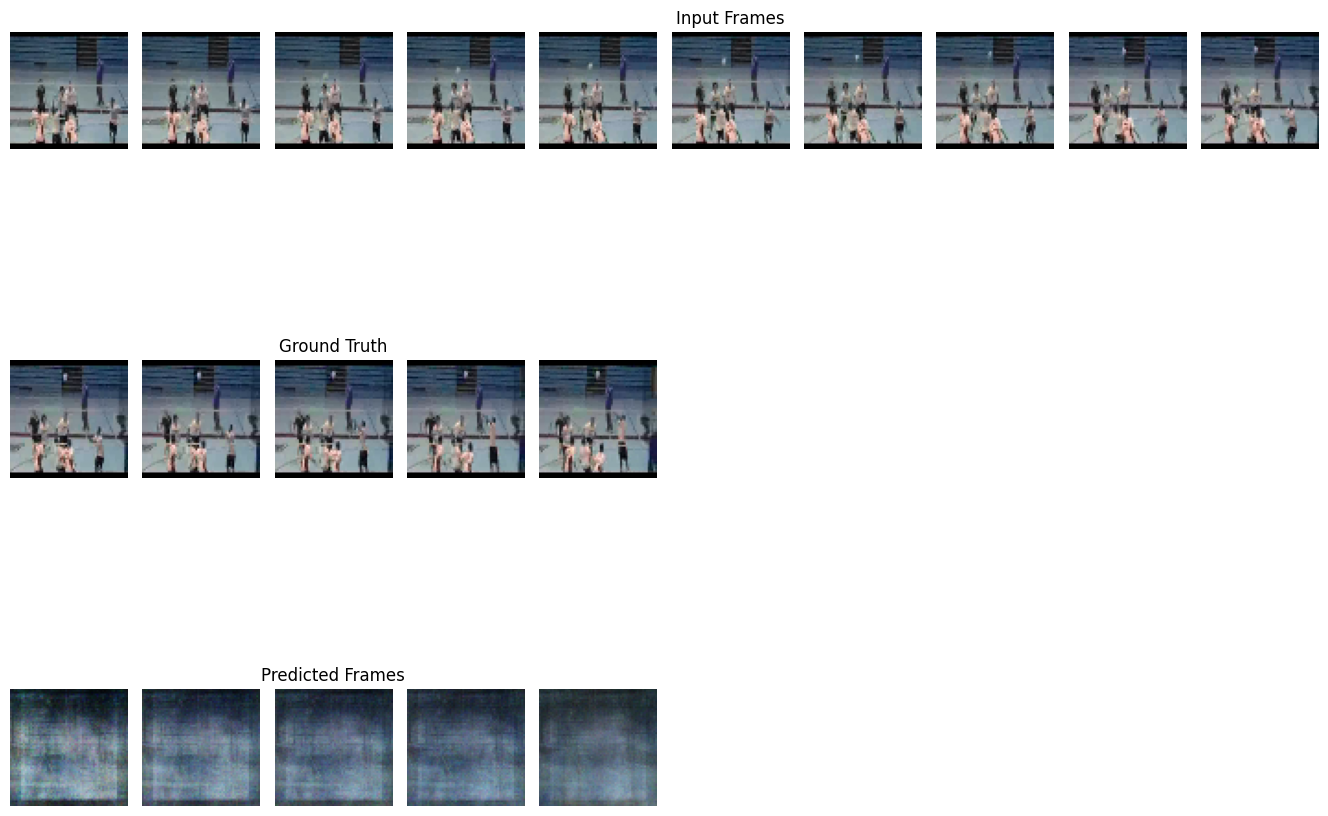

Evaluating model SSIM...
Average SSIM across the test set: 0.0978


In [6]:
def visualize_predictions(model, test_gen_viz, input_frames, output_frames, batch_size=1):
    """
    Visualizes predictions for a specified number of samples from the test set.

    Parameters:
    - model: Trained Keras model.
    - test_gen_viz: Instance of DataGenerator for test data with batch_size=1.
    - input_frames: Number of input frames.
    - output_frames: Number of output frames to predict.
    - batch_size: Number of samples to visualize.
    """
    try:
        for i in range(batch_size):
            # Fetch the i-th batch (since batch_size=1, i=0)
            X_test, Y_true = test_gen_viz[i]
            
            # Check shapes
            print(f"X_test shape: {X_test.shape}")  # Expected: (1, 10, 64, 64, 3)
            print(f"Y_true shape: {Y_true.shape}")  # Expected: (1, 5, 64, 64, 3)
            
            # Predict Y_pred
            Y_pred = model.predict(X_test)
            
            # Check Y_pred shape
            print(f"Y_pred shape: {Y_pred.shape}")  # Expected: (1, 5, 64, 64, 3)
            
            # Since batch_size=1, take the first (and only) sample
            X_sample = X_test[0]       # Shape: (10, 64, 64, 3)
            Y_true_sample = Y_true[0] # Shape: (5, 64, 64, 3)
            Y_pred_sample = Y_pred[0] # Shape: (5, 64, 64, 3)

            plt.figure(figsize=(20, 10))
            total_frames = input_frames + output_frames

            # Plot input frames
            for j in range(input_frames):
                plt.subplot(3, total_frames, j + 1)
                plt.imshow(X_sample[j])
                plt.axis('off')
                if j == input_frames // 2:
                    plt.title("Input Frames")

            # Plot ground truth frames
            for j in range(output_frames):
                plt.subplot(3, total_frames, total_frames + j + 1)
                plt.imshow(Y_true_sample[j])
                plt.axis('off')
                if j == output_frames // 2:
                    plt.title("Ground Truth")

            # Plot predicted frames
            for j in range(output_frames):
                plt.subplot(3, total_frames, 2 * total_frames + j + 1)
                plt.imshow(Y_pred_sample[j])
                plt.axis('off')
                if j == output_frames // 2:
                    plt.title("Predicted Frames")

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print("Error during visualization:", e)

# 13. Define the Corrected SSIM Evaluation Function
def evaluate_ssim(model, test_gen, input_frames, output_frames):
    """
    Computes the average SSIM (Structural Similarity Index) over the test set.

    Parameters:
    - model: Trained Keras model.
    - test_gen: Instance of DataGenerator for test data.
    - input_frames: Number of input frames.
    - output_frames: Number of output frames to predict.

    Returns:
    - avg_ssim: Average SSIM over the test set.
    """
    # Predict all Y_preds at once
    Y_preds = model.predict(test_gen, steps=len(test_gen), verbose=0)

    # Collect all Y_trues
    Y_trues = []
    for i in range(len(test_gen)):
        X, Y = test_gen[i]
        Y_trues.append(Y)
    Y_trues = np.concatenate(Y_trues, axis=0)

    # Ensure Y_preds and Y_trues have the same shape
    if Y_preds.shape != Y_trues.shape:
        print(f"Shape mismatch: Y_preds shape {Y_preds.shape}, Y_trues shape {Y_trues.shape}")
        return None

    total_ssim = 0
    total_frames = Y_trues.shape[0] * Y_trues.shape[1]

    # Iterate over each frame to compute SSIM
    for b in range(Y_trues.shape[0]):
        for t in range(Y_trues.shape[1]):
            true_frame = Y_trues[b, t]
            pred_frame = Y_preds[b, t]

            # Convert to grayscale
            true_gray = tf.image.rgb_to_grayscale(true_frame).numpy().squeeze()
            pred_gray = tf.image.rgb_to_grayscale(pred_frame).numpy().squeeze()

            # Calculate SSIM
            ssim_val = ssim(true_gray, pred_gray, data_range=1.0)
            total_ssim += ssim_val

    # Calculate average SSIM
    avg_ssim = total_ssim / total_frames
    print(f"Average SSIM across the test set: {avg_ssim:.4f}")
    return avg_ssim

# 14. Initialize a Separate DataGenerator for Visualization with batch_size=1
test_gen_viz = DataGenerator(
    preprocessed_dir=preprocessed_test_dir, 
    input_frames=input_frames, 
    output_frames=output_frames, 
    batch_size=1
)

# 15. Visualize Predictions
print("Visualizing predictions...")
visualize_predictions(
    model=model, 
    test_gen_viz=test_gen_viz, 
    input_frames=input_frames, 
    output_frames=output_frames, 
    batch_size=1
)

# 16. Evaluate SSIM
print("Evaluating model SSIM...")
average_ssim = evaluate_ssim(model, test_gen, input_frames, output_frames)

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# ========================
# 1. Define the DataGenerator
# ========================

class DataGenerator(Sequence):
    def __init__(self, preprocessed_dir, input_frames=10, output_frames=5, batch_size=1):
        """
        Initialization
        
        Parameters:
        - preprocessed_dir: Directory containing preprocessed .npy files organized by class.
        - input_frames: Number of frames to use as input.
        - output_frames: Number of frames to predict.
        - batch_size: Number of samples per batch.
        """
        self.preprocessed_dir = preprocessed_dir
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.batch_size = batch_size
        self.file_list = self._get_file_list()
        self.indexes = np.arange(len(self.file_list))
        self.on_epoch_end()
        print(f"Initialized DataGenerator with {len(self.file_list)} files.")

    def _get_file_list(self):
        """
        Retrieves a list of all .npy files in the preprocessed directory.
        """
        file_list = []
        for class_name in os.listdir(self.preprocessed_dir):
            class_dir = os.path.join(self.preprocessed_dir, class_name)
            if os.path.isdir(class_dir):
                for file in os.listdir(class_dir):
                    if file.endswith('.npy'):
                        file_list.append(os.path.join(class_dir, file))
        return file_list

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return int(np.floor(len(self.file_list) / self.batch_size))

    def on_epoch_end(self):
        """
        Shuffles indexes after each epoch.
        """
        np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        X_batch, Y_batch = [], []
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        for idx in batch_indexes:
            file = self.file_list[idx]
            try:
                video_data = np.load(file)
            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue
            # Normalize data if not already normalized
            if video_data.max() > 1.0:
                video_data = video_data / 255.0
            total_frames = len(video_data)
            max_start_idx = total_frames - self.input_frames - self.output_frames
            if max_start_idx <= 0:
                print(f"Skipping file {file}: not enough frames.")
                continue
            start_idx = np.random.randint(0, max_start_idx + 1)
            X = video_data[start_idx:start_idx + self.input_frames]
            Y = video_data[start_idx + self.input_frames:start_idx + self.input_frames + self.output_frames]
            X_batch.append(X)
            Y_batch.append(Y)
        if not X_batch or not Y_batch:
            print(f"No valid data in batch {index}. Returning empty arrays.")
            return np.empty((0, self.input_frames, 64, 64, 3)), np.empty((0, self.output_frames, 64, 64, 3))
        X_batch = np.array(X_batch)
        Y_batch = np.array(Y_batch).astype(np.float32)
        return X_batch, Y_batch

# ========================
# 2. Define Custom Layers for PredRNN
# ========================

class ST_LSTM_Cell(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ST_LSTM_Cell, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        # Define convolutional layers
        self.conv_xh = tf.keras.layers.Conv2D(
            filters=4 * filters,
            kernel_size=kernel_size,
            padding='same'
        )
        self.conv_m = tf.keras.layers.Conv2D(
            filters=3 * filters,
            kernel_size=kernel_size,
            padding='same'
        )
        self.conv_o = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding='same'
        )

    def call(self, x_t, h_prev, c_prev, m_prev):
        # Compute gates
        xh = self.conv_xh(tf.concat([x_t, h_prev], axis=-1))
        i_xh, f_xh, g_xh, o_xh = tf.split(xh, num_or_size_splits=4, axis=-1)

        m = self.conv_m(m_prev)
        i_m, f_m, m_m = tf.split(m, num_or_size_splits=3, axis=-1)

        # Update states
        i_t = tf.sigmoid(i_xh + i_m)
        f_t = tf.sigmoid(f_xh + f_m)
        g_t = tf.tanh(g_xh)
        c_t = f_t * c_prev + i_t * g_t

        m_t = f_t * m_prev + i_t * tf.tanh(m_m)

        o_t = tf.sigmoid(o_xh + self.conv_o(m_t))
        h_t = o_t * tf.tanh(c_t)

        return h_t, c_t, m_t

class PredRNNLayer(tf.keras.layers.Layer):
    def __init__(self, filters, num_layers, input_frames, output_frames, kernel_size=(3, 3), **kwargs):
        super(PredRNNLayer, self).__init__(**kwargs)
        self.filters = filters
        self.num_layers = num_layers
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.kernel_size = kernel_size
        # Create ST-LSTM cells for each layer
        self.stlstm_cells = [ST_LSTM_Cell(filters, kernel_size) for _ in range(num_layers)]
        # Output convolution
        self.conv_output = tf.keras.layers.Conv2D(
            filters=3,  # Assuming RGB output
            kernel_size=(1, 1),
            activation='sigmoid',
            padding='same'
        )

    def call(self, inputs, training=None):
        # inputs.shape: (batch_size, input_frames, height, width, channels)
        input_frames = self.input_frames
        output_frames = self.output_frames
        total_frames = input_frames + output_frames

        # Get static shape dimensions if possible
        batch_size = tf.shape(inputs)[0]
        height = inputs.shape[2]
        width = inputs.shape[3]
        channels = inputs.shape[4]

        # Handle dynamic height and width
        if height is None:
            height = tf.shape(inputs)[2]
        if width is None:
            width = tf.shape(inputs)[3]

        # Initialize states
        h_t = [tf.zeros((batch_size, height, width, self.filters)) for _ in range(self.num_layers)]
        c_t = [tf.zeros((batch_size, height, width, self.filters)) for _ in range(self.num_layers)]
        m_t = tf.zeros((batch_size, height, width, self.filters))

        outputs = []

        for t in range(total_frames):
            if t < input_frames:
                x_t = inputs[:, t]
            else:
                x_t = x_pred  # Use last predicted frame

            h_t_prev = h_t.copy()
            c_t_prev = c_t.copy()
            m_t_prev = m_t

            for l in range(self.num_layers):
                if l == 0:
                    h, c, m_t = self.stlstm_cells[l](x_t, h_t_prev[l], c_t_prev[l], m_t_prev)
                else:
                    h, c, m_t = self.stlstm_cells[l](h_t[l-1], h_t_prev[l], c_t_prev[l], m_t)
                h_t[l] = h
                c_t[l] = c

            x_pred = self.conv_output(h_t[-1])

            if t >= input_frames:
                outputs.append(x_pred)

        outputs = tf.stack(outputs, axis=1)
        return outputs

# ========================
# 3. Define the Video Generation Function
# ========================

def generate_video(model, test_gen, video_filename, input_frames=10, output_frames=5, img_size=(64, 64)):
    """
    Generates a video showing input frames followed by predicted frames.

    Parameters:
    - model: Trained Keras model.
    - test_gen: Instance of DataGenerator for test data.
    - video_filename: Path to save the output video.
    - input_frames: Number of input frames.
    - output_frames: Number of frames to predict.
    - img_size: Tuple indicating the frame size (height, width).
    """
    try:
        # Fetch a single batch from the test generator
        X_test, Y_true = test_gen.__getitem__(0)
        
        if X_test.size == 0 or Y_true.size == 0:
            print("Empty batch received. Skipping video generation.")
            return
        
        # Make predictions
        Y_pred = model.predict(X_test)
        
        # Initialize the video writer
        fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec
        fps = 10  # Frames per second
        video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (img_size[1], img_size[0]))
        
        # Add input frames to the video
        for t in range(input_frames):
            frame = (X_test[0, t] * 255).astype(np.uint8)  # Scale to 0-255
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
            video_writer.write(frame_bgr)
        
        # Add predicted frames to the video
        for t in range(output_frames):
            frame = (Y_pred[0, t] * 255).astype(np.uint8)  # Scale to 0-255
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
            video_writer.write(frame_bgr)
        
        video_writer.release()
        print(f"Video saved to {video_filename}")
    
    except Exception as e:
        print(f"Error during video generation: {e}")

# ========================
# 4. Load Trained Models
# ========================

# Paths to the trained models
convlstm_best_model_path = '/kaggle/working/convlstm_best_model1.keras'
convlstm_final_model_path = '/kaggle/working/convlstm_final_model1.keras'
predrnn_best_model_path = '/kaggle/working/predrnn_best_model.keras'
transformer_best_model_path = '/kaggle/working/enhanced_transformer_model.keras'

# Load the ConvLSTM Best Model
try:
    convlstm_best_model = load_model(convlstm_best_model_path)
    print("ConvLSTM Best Model loaded successfully.")
except Exception as e:
    convlstm_best_model = None
    print(f"Error loading ConvLSTM Best Model: {e}")

# Load the ConvLSTM Final Model
try:
    convlstm_final_model = load_model(convlstm_final_model_path)
    print("ConvLSTM Final Model loaded successfully.")
except Exception as e:
    convlstm_final_model = None
    print(f"Error loading ConvLSTM Final Model: {e}")

# Load the PredRNN Best Model
try:
    predrnn_model = load_model(
        predrnn_best_model_path,
        custom_objects={
            'PredRNNLayer': PredRNNLayer,m
            'ST_LSTM_Cell': ST_LSTM_Cell
        }
    )
    print("PredRNN Best Model loaded successfully.")
except Exception as e:
    predrnn_model = None
    print(f"Error loading PredRNN Best Model: {e}")

# Load the Transformer Best Model
try:
    transformer_model = load_model(transformer_best_model_path)
    print("Transformer Best Model loaded successfully.")
except Exception as e:
    transformer_model = None
    print(f"Error loading Transformer Best Model: {e}")

# ========================
# 5. Initialize the Test Data Generator
# ========================

# Path to your preprocessed test dataset
preprocessed_test_dir = '/kaggle/working/preprocessed_test'

# Initialize the test data generator with batch_size=1
test_gen_video = DataGenerator(
    preprocessed_dir=preprocessed_test_dir,
    input_frames=10,
    output_frames=5,
    batch_size=1
)

# ========================
# 6. Generate Videos for All Models
# ========================

# List of models and their corresponding video filenames
models_info = [
    (convlstm_best_model, '/kaggle/working/convlstm_best_predictionsD.avi'),
    (convlstm_final_model, '/kaggle/working/convlstm_final_predictionsD.avi'),
    (predrnn_model, '/kaggle/working/predrnn_best_predictionsD.avi'),
    (transformer_model, '/kaggle/working/transformer_best_predictionsD.avi')
]

# Generate videos for each model
for model, video_path in models_info:
    if model is not None:
        model_name = model.name if hasattr(model, 'name') else 'Unnamed_Model'
        print(f"\nGenerating video for model: {model_name}")
        generate_video(
            model=model,
            test_gen=test_gen_video,
            video_filename=video_path,
            input_frames=10,
            output_frames=5,
            img_size=(64, 64)
        )
        # Reset the generator for the next model
        test_gen_video.on_epoch_end()
    else:
        print(f"Model not loaded. Skipping video generation for {video_path}.")

print("\nAll videos generated successfully.")


ConvLSTM Best Model loaded successfully.
ConvLSTM Final Model loaded successfully.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'pred_rnn_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


PredRNN Best Model loaded successfully.
Error loading Transformer Best Model: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_4', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 10, 64, 64, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}, 'registered_name': None, 'name': 'input_layer_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'TimeDistributed', 'config': {'name': 'time_distributed', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [None, 10, 64, 64, 3]}, 'name': 'time_distributed', 'inbound_nodes': [{'args': 

I0000 00:00:1733168237.638051    2357 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_1', 12 bytes spill stores, 12 bytes spill loads



In [8]:
!pip install moviepy


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 70.9 MB/s eta 0:00:00:00:0100:01


In [9]:
!pip install --force-reinstall moviepy


  Using cached moviepy-2.1.1-py3-none-any.whl.metadata (6.9 kB)
  Using cached imageio_ffmpeg-0.5.1-py3-none-manylinux2010_x86_64.whl.metadata (1.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
  Using cached proglog-0.1.10-py3-none-any.whl.metadata (639 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.2 MB/s eta 0:00:00
Using cached moviepy-2.1.1-py3-none-any.whl (123 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 13.8 MB/s eta 0:00:00
Using cached imageio_ffmpeg-0.5.1-py3-none-manylinux2010_x86_64.whl (26.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 92.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.0 MB/s eta 0:00:00:00:01
Using cached proglog-0.1.10-py3-none-any.whl (6.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: tq

In [10]:
# 17. Generate Video for Transformer Model
def generate_transformer_video(model, test_gen, video_filename, input_frames=10, output_frames=5, img_size=(64, 64)):
    """
    Generates a video showing input frames followed by predicted frames using the Transformer model.

    Parameters:
    - model: Trained Keras Transformer model.
    - test_gen: Instance of DataGenerator for test data.
    - video_filename: Path to save the output video.
    - input_frames: Number of input frames.
    - output_frames: Number of frames to predict.
    - img_size: Tuple indicating the frame size (height, width).
    """
    try:
        # Fetch a single batch from the test generator
        X_test, Y_true = test_gen.__getitem__(0)
        
        if X_test.size == 0 or Y_true.size == 0:
            print("Empty batch received. Skipping video generation.")
            return
        
        # Make predictions
        Y_pred = model.predict(X_test)
        
        # Initialize the video writer
        fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec
        fps = 10  # Frames per second
        video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (img_size[1], img_size[0]))
        
        # Add input frames to the video
        for t in range(input_frames):
            frame = (X_test[0, t] * 255).astype(np.uint8)  # Scale to 0-255
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
            video_writer.write(frame_bgr)
        
        # Add predicted frames to the video
        for t in range(output_frames):
            frame = (Y_pred[0, t] * 255).astype(np.uint8)  # Scale to 0-255
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
            video_writer.write(frame_bgr)
        
        video_writer.release()
        print(f"Video saved to {video_filename}")
    
    except Exception as e:
        print(f"Error during video generation: {e}")

# Generate and display the video
output_video_path = 'prediction_video_transformer.avi'
generate_transformer_video(
    model=model,
    test_gen=test_gen_viz,
    video_filename=output_video_path,
    input_frames=input_frames,
    output_frames=output_frames,
    img_size=(img_height, img_width)
)

# Display the generated video
try:
    display(Video(output_video_path))
except Exception as e:
    print("Error displaying video:", e)


Error during video generation: 'NoneType' object has no attribute 'predict'
Error displaying video: name 'Video' is not defined


In [11]:
import shutil

# Specify the directory you want to zip (use '.' for the current working directory)
directory_to_zip = '.'

# Define the name of the output zip file
output_zip = '/kaggle/working/my_project.zip'

# Create a zip file
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', directory_to_zip)


OSError: [Errno 28] No space left on device

In [3]:
!pip install google-colab


ERROR: Could not find a version that satisfies the requirement google-colab (from versions: none)
ERROR: No matching distribution found for google-colab


In [ ]:
# Cloud Storage
from google.cloud import storage
storage_client = storage.Client(project='Deep final project')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 103.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.147.0
    Uninstalling google-api-python-client-2.147.0:
      Successfully uninstalled google-api-python-client-2.147.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.154.0 which is incompatible.
